In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as T
import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import time
from torchvision import models
import torch
from torch.utils.data import Dataset
import nibabel as nib
import numpy as np
import torchvision.transforms as T
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import os
from os.path import join
import glob

In [7]:
def addPathColumn(base_dir, csv_path):
    image_to_path_df = pd.DataFrame(columns=["Image Data ID", "path"])
    
    for parent in glob.iglob(os.path.join(base_dir, "ADNI_Preprocessed", "**", "*"), recursive=True):
        if os.path.isdir(parent):
            id = os.path.basename(parent)
            try:
                path = next(glob.iglob(os.path.join(parent, '*')))
            except StopIteration:
                continue  # No file in the folder
            temp_df = pd.DataFrame({"Image Data ID": [id], "path": [path]})
            image_to_path_df = pd.concat([image_to_path_df, temp_df], ignore_index=True)

    adni_df = pd.read_csv(csv_path)
    adni_df = pd.merge(adni_df, image_to_path_df, on='Image Data ID', how='left')
    adni_df.to_csv("adni_with_path.csv", index=False)

    return adni_df

addPathColumn("/kaggle/input/adni-preprocessed", "/kaggle/input/metadata-adni/ADNI1_Complete_1Yr_1.5T_6_20_2025.csv")

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded,path
0,I112538,941_S_1311,MCI,M,70,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,6/01/2008,NiFTI,NaN,/kaggle/input/adni-preprocessed/ADNI_Preproces...
1,I97341,941_S_1311,MCI,M,70,m06,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,9/27/2007,NiFTI,NaN,NaN
2,I97327,941_S_1311,MCI,M,69,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/02/2007,NiFTI,NaN,/kaggle/input/adni-preprocessed/ADNI_Preproces...
3,I75150,941_S_1202,CN,M,78,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,8/24/2007,NiFTI,NaN,NaN
4,I105437,941_S_1202,CN,M,79,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,2/28/2008,NiFTI,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2289,I118671,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,4/18/2006,NiFTI,NaN,NaN
2290,I118692,002_S_0295,CN,M,85,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,11/02/2006,NiFTI,NaN,NaN
2291,I64025,002_S_0295,CN,M,86,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,5/25/2007,NiFTI,NaN,NaN
2292,I45108,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI,NaN,NaN


In [4]:
code = {'AD':1, 'CN':0}
class ADNIAxialDataset(Dataset):
    def __init__(self, csv_path, transform=None, n_slices=80):
        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df.Group != "MCI"]
        self.df = self.df.dropna(subset=['path'])
        self.transform = transform
        self.n_slices = n_slices

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]['path']
        label = code[self.df.iloc[idx]['Group']]

        img = nib.load(path).get_fdata()  # shape: (H, W, D)
        img = np.transpose(img, (2, 0, 1))  # axial: (D, H, W)

        center = img.shape[0] // 2
        start = center - self.n_slices // 2
        end = center + self.n_slices // 2
        slices = img[start:end]  # shape: (n_slices, H, W)

        if self.transform:
            slices = torch.stack([self.transform(slice_) for slice_ in slices])
        else:
            slices = torch.tensor(slices).unsqueeze(1).float()  # (N, 1, H, W)

        return slices, label

In [5]:
class AttentionFusion(nn.Module):
    def __init__(self, fdim):
        super().__init__()
        self.attn = nn.Linear(fdim, 1)

    def forward(self, features):  # (B, N, fdim)
        weights = self.attn(features).squeeze(-1)  # (B, N)
        alpha = torch.softmax(weights, dim=1).unsqueeze(-1)  # (B, N, 1)
        fused = (alpha * features).sum(dim=1)  # (B, fdim)
        return fused

class AXIALModel(nn.Module):
    def __init__(self):
        super().__init__()

        base_model = models.vgg16(pretrained=True)

        # Freeze only convolutional layers
        self.features = base_model.features
        for param in self.features.parameters():
            param.requires_grad = False

        # Keep dense layers trainable
        self.classifier_layers = base_model.classifier  # fully connected layers
        for param in self.classifier_layers.parameters():
            param.requires_grad = True

        self.pool = nn.AdaptiveAvgPool2d((7, 7))  # VGG16 expects this size before FC
        self.flatten = nn.Flatten()

        self.fdim = 4096  # Output of second FC in VGG16
        self.attn_fusion = AttentionFusion(self.fdim)
        self.dropout = nn.Dropout(0.3)
        self.final_classifier = nn.Linear(self.fdim, 2)
        self.project = nn.Linear(25088, 4096)

    def forward(self, x):  # x: (B, N, 1, 224, 224)
        B, N, _, H, W = x.shape
        x = x.view(B * N, 1, H, W)
        x = x.repeat(1, 3, 1, 1)  # convert to 3 channels
        x = self.features(x)
        x = self.pool(x)
        x = self.flatten(x)  # (B*N, fdim)
        x = self.project(x)
        x = x.view(B, N, -1)
        fused = self.attn_fusion(x)
        fused = self.dropout(fused)
        out = self.final_classifier(fused)
        return out

In [6]:
from tqdm import tqdm
def train_model(model, train_loader, val_loader, epochs, device):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
    class_weights = compute_class_weight('balanced', classes=[0, 1], y=(df["Group"]=="AD").values)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    best_acc = 0
    train_loss, train_acc = [], []
    val_accs = []
    for epoch in range(epochs):
        model.train()
        losses, preds, labels = [], [], []
        scaler = torch.amp.GradScaler('cuda')
        
        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device)
            
            with torch.amp.autocast("cuda"):
                out = model(x)
                loss = criterion(out, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            losses.append(loss.item())
            preds.extend(out.argmax(1).cpu().numpy())
            labels.extend(y.cpu().numpy())
        acc = accuracy_score(labels, preds)
        print(f"[Epoch {epoch+1}] Train Loss: {sum(losses)/len(losses):.4f}, Acc: {acc:.4f}")
        train_loss.append(sum(losses)/len(losses))
        train_acc.append(acc)

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                val_preds.extend(out.argmax(1).cpu().numpy())
                val_labels.extend(y.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        print(f"          Val Acc: {val_acc:.4f}")
        val_accs.append(val_acc)
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
        torch.cuda.empty_cache()
    return train_loss, train_acc, val_accs

In [10]:
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
])

# Load and filter BEFORE splitting
df = pd.read_csv("/kaggle/input/adni-csv-with-path/adni_with_path.csv")
df = df[df.Group != 'MCI']
df = df.dropna(subset=['path'])  # Ensure valid paths only

# Stratified split
train_idx, val_idx = train_test_split(df.index, test_size=0.2, stratify=df["Group"])

# Save filtered df to temp CSV
df.to_csv("filtered_adni.csv", index=False)

# Use filtered CSV with correct indices
train_ds = ADNIAxialDataset("filtered_adni.csv", transform=transform)
val_ds   = ADNIAxialDataset("filtered_adni.csv", transform=transform)

train_loader = DataLoader(Subset(train_ds, train_ds.df.index.get_indexer(train_idx)), batch_size=1, shuffle=True)
val_loader   = DataLoader(Subset(val_ds,   val_ds.df.index.get_indexer(val_idx)),   batch_size=1, shuffle=False)


model = AXIALModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, epochs=20, device=device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 208MB/s]  
100%|██████████| 186/186 [01:08<00:00,  2.72it/s]


[Epoch 1] Train Loss: 1.6373, Acc: 0.9355
          Val Acc: 0.9574


100%|██████████| 186/186 [01:05<00:00,  2.84it/s]


[Epoch 2] Train Loss: 4.3428, Acc: 0.9677
          Val Acc: 0.9149


100%|██████████| 186/186 [01:04<00:00,  2.87it/s]


[Epoch 3] Train Loss: 0.7096, Acc: 0.9570
          Val Acc: 0.9149


100%|██████████| 186/186 [01:04<00:00,  2.89it/s]


[Epoch 4] Train Loss: 0.3934, Acc: 0.9624
          Val Acc: 0.9574


100%|██████████| 186/186 [01:03<00:00,  2.91it/s]


[Epoch 5] Train Loss: 0.5328, Acc: 0.9570
          Val Acc: 0.9574


100%|██████████| 186/186 [01:04<00:00,  2.88it/s]


[Epoch 6] Train Loss: 1.2772, Acc: 0.9677
          Val Acc: 0.9149


100%|██████████| 186/186 [01:03<00:00,  2.91it/s]


[Epoch 7] Train Loss: 0.1665, Acc: 0.9731
          Val Acc: 0.9149


100%|██████████| 186/186 [01:04<00:00,  2.90it/s]


[Epoch 8] Train Loss: 0.3436, Acc: 0.9785
          Val Acc: 0.9362


100%|██████████| 186/186 [01:03<00:00,  2.91it/s]


[Epoch 9] Train Loss: 0.0616, Acc: 0.9892
          Val Acc: 0.9574


100%|██████████| 186/186 [01:03<00:00,  2.93it/s]


[Epoch 10] Train Loss: 0.0840, Acc: 0.9839
          Val Acc: 0.9574


100%|██████████| 186/186 [01:03<00:00,  2.93it/s]


[Epoch 11] Train Loss: 0.0825, Acc: 0.9839
          Val Acc: 0.9574


100%|██████████| 186/186 [01:03<00:00,  2.91it/s]


[Epoch 12] Train Loss: 0.1402, Acc: 0.9839
          Val Acc: 0.9574


100%|██████████| 186/186 [01:03<00:00,  2.92it/s]


[Epoch 13] Train Loss: 0.1124, Acc: 0.9839
          Val Acc: 0.9574


100%|██████████| 186/186 [01:04<00:00,  2.90it/s]


[Epoch 14] Train Loss: 0.1156, Acc: 0.9839
          Val Acc: 0.9574


100%|██████████| 186/186 [01:03<00:00,  2.94it/s]


[Epoch 15] Train Loss: 0.0672, Acc: 0.9839
          Val Acc: 0.9574


100%|██████████| 186/186 [01:03<00:00,  2.91it/s]


[Epoch 16] Train Loss: 0.0661, Acc: 0.9839
          Val Acc: 0.9149


100%|██████████| 186/186 [01:03<00:00,  2.91it/s]


[Epoch 17] Train Loss: 0.0573, Acc: 0.9839
          Val Acc: 0.9574


100%|██████████| 186/186 [01:03<00:00,  2.91it/s]


[Epoch 18] Train Loss: 0.0875, Acc: 0.9892
          Val Acc: 0.9362


100%|██████████| 186/186 [01:03<00:00,  2.91it/s]


[Epoch 19] Train Loss: 0.0320, Acc: 0.9946
          Val Acc: 0.9149


100%|██████████| 186/186 [01:03<00:00,  2.91it/s]


[Epoch 20] Train Loss: 0.1292, Acc: 0.9839
          Val Acc: 0.9149


Accuracy:  0.9149
Precision: 0.3333
Recall:    1.0000
F1-score:  0.5000
Confusion Matrix:
[[41  4]
 [ 0  2]]


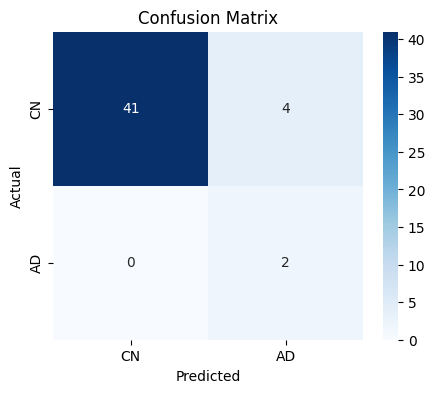

20


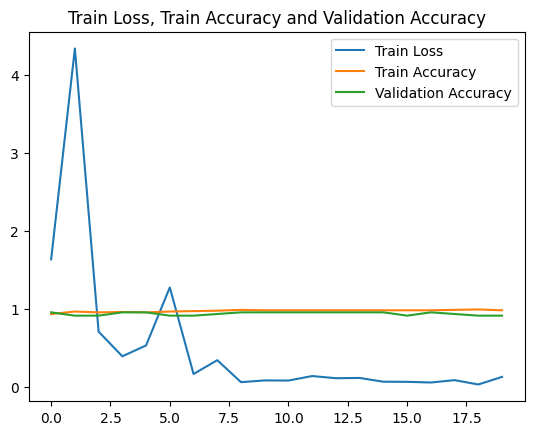

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(m_name, model, test_loader, device, train_loss, train_acc, val_acc):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            if isinstance(outputs, tuple):  # If model returns (logits, attention)
                outputs = outputs[0]
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    # Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["CN", "AD"], yticklabels=["CN", "AD"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig(f"{m_name}_confusion_matrix.png")
    plt.show()

    plt.plot(train_loss, label='Train Loss')
    print(len(train_loss),end='\n')
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label= 'Validation Accuracy')
    plt.legend()
    plt.title("Train Loss, Train Accuracy and Validation Accuracy")
    plt.savefig(f"{m_name}_loss_and_acc_graph.png")
    plt.show()

evaluate_model("mobile_net",model, val_loader, device, train_loss, train_acc, val_acc)